In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from tqdm import tqdm

In [38]:
project_dir = '/Users/TrexK/Documents/nfl-databowl/data'
os.listdir(project_dir)

['plays.csv',
 'tackles.csv',
 'tracking_week_5.csv',
 'tracking_week_4.csv',
 'tracking_week_6.csv',
 'tracking_week_7.csv',
 'tracking_week_3.csv',
 'tracking_week_2.csv',
 'tracking_week_1.csv',
 'players.csv',
 'games.csv',
 'tracking_week_9.csv',
 'tracking_week_8.csv']

In [54]:
# Re-executing the provided code to load player data, week data, plays data, and merge them
import pandas as pd

project_dir = '/Users/TrexK/Documents/nfl-databowl/data'

# Load player data
players = pd.read_csv(f"{project_dir}/players.csv")

# Load plays data
plays = pd.read_csv(f"{project_dir}/plays.csv")

# Load data from one week
week = pd.read_csv(f"{project_dir}/tracking_week_1.csv")

# Join player positioning information onto a week's worth of tracking data
week = week.merge(players.loc[:, ['nflId', 'position']], how='left')

# Now, merge the playResult from plays onto the week data by the common gameId and playId
week = week.merge(plays[['gameId', 'playId', 'playResult', 'absoluteYardlineNumber']], on=['gameId', 'playId'], how='left')

# Output the shape of the merged DataFrame
week.head()


,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,position,playResult,absoluteYardlineNumber
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,G,6,85
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived,G,6,85
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN,G,6,85
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,88.64,26.90,1.44,0.89,0.14,232.38,145.42,NaN,G,6,85
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,88.72,26.80,1.29,1.24,0.13,233.36,141.95,NaN,G,6,85


In [55]:
gid = 2022090800 #randomly sampled game 
game = week.loc[week['gameId']==gid].copy()
game.shape

(79212, 20)

In [56]:
# new dataframe for data 
df = pd.DataFrame()
for pid in tqdm(game['playId'].unique(), leave=True):
    # subset data down to one play
    play = game.loc[game['playId']==pid].copy()

    for fid in tqdm(play['frameId'].unique(), leave=False):
        # subset data down to one frame 
        frame = play.loc[play['frameId']==fid].copy()

        # make unique positions, as to not duplicate columns based on player position
        frame['pos_unique'] = (frame['position']
                            .add(frame
                                  .groupby('position', as_index=False)
                                  .cumcount()
                                  .add(1)
                                  .dropna()
                                  .astype(str)
                                  .str.replace('.0','', regex=False)
                                  .str.replace('0','', regex=False)))

        # calc distances 
        _df = (pd
             .DataFrame(cdist(frame.loc[:, ['x', 'y']], 
                              frame.loc[:, ['x', 'y']]), 
                        index=frame['nflId'], 
                        columns=frame['pos_unique'].fillna('football')))

        # reset index to pop out nflId into its own column
        _df = _df.reset_index()

        # merge new distance values onto original dataframe
        frame = frame.merge(_df)

        # concatenate new results into the output dataframe 
        df = pd.concat([df,frame])

100%|██████████| 91/91 [00:16<00:00,  5.40it/s]


In [57]:
df.loc[:, ['gameId', 'x','y','playId', 'nflId', 'displayName', 'frameId',
           'pos_unique','QB1', 'WR3','football','playResult', 'absoluteYardlineNumber']].sample(20)

,gameId,x,y,playId,nflId,displayName,frameId,pos_unique,QB1,WR3,football,playResult,absoluteYardlineNumber
11,2022090800,63.94,29.54,146,46076.0,Josh Allen,13,QB1,0.000000,10.141765,1.549839,2,59
7,2022090800,92.76,28.16,3121,42400.0,Rob Havenstein,6,T1,3.369421,35.806427,14.597455,9,86
21,2022090800,51.16,13.63,2934,53532.0,Ernest Jones,20,ILB2,16.664483,39.868143,0.240832,1,51
5,2022090800,52.82,28.79,1836,41341.0,DaQuan Jones,5,DT1,3.264552,13.609592,14.633295,-1,48
12,2022090800,78.31,26.04,3145,46158.0,Joseph Noteboom,6,T2,5.219387,7.767091,3.732692,1,77
13,2022090800,89.63,27.64,2815,46180.0,Brian Allen,15,C1,5.747834,27.354819,27.491186,10,88
17,2022090800,13.18,5.15,2208,48026.0,Nick Scott,47,SS1,26.326906,34.559845,6.314499,8,25
2,2022090800,94.86,15.06,2485,42392.0,Mitch Morse,44,C1,9.032768,NaN,8.703524,8,96
11,2022090800,48.49,20.01,646,47844.0,Taylor Rapp,12,FS1,23.382258,12.453112,15.643655,20,62
19,2022090800,71.03,29.03,3190,53490.0,Carlos Basham,16,DE2,8.487338,12.524556,22.730563,5,70


In [58]:
# Select the relevant columns
data = df[['football', 'playResult']]

# Drop any rows with missing values
data = data.dropna()

# Split the data into inputs (X) and the target variable (y)
X = data[['football']]
y = data['playResult']

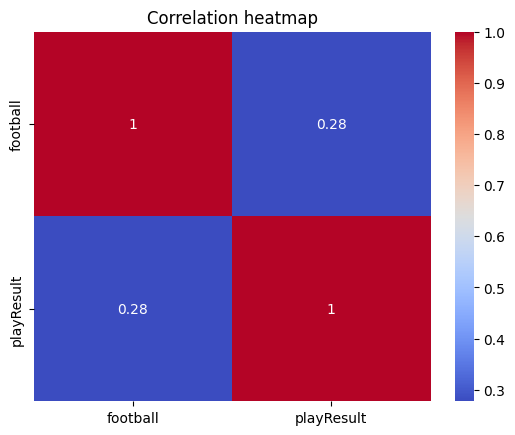

In [63]:
import seaborn as sns

# Calculate correlation matrix
corr = data[['football', 'playResult']].corr()

# Create a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')

plt.title('Correlation heatmap')
plt.show()

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Split the data into inputs (X) and the target variable (y)
X = data[['football']]
y = data['playResult']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"Linear Regression RMSE: {mean_squared_error(y_test, y_pred_lr, squared=False)}")

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print(f"Decision Tree RMSE: {mean_squared_error(y_test, y_pred_dt, squared=False)}")

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"Random Forest RMSE: {mean_squared_error(y_test, y_pred_rf, squared=False)}")

Linear Regression RMSE: 7.076977910853345
Decision Tree RMSE: 9.582769507657503
Random Forest RMSE: 8.222742587566929


In [99]:
# Create a DataFrame with the input feature and actual values
results = pd.DataFrame({'Football': X_test['football'], 'Actual': y_test})

# Add the predicted values from each model
results['Linear Regression Predicted'] = y_pred_lr
results['Decision Tree Predicted'] = y_pred_dt
results['Random Forest Predicted'] = y_pred_rf

# Display the DataFrame
results.head()

,Football,Actual,Linear Regression Predicted,Decision Tree Predicted,Random Forest Predicted
10,20.159770,2,8.634637,2.0,2.040000
14,15.766816,8,7.722002,7.0,5.870000
21,7.689663,4,6.043976,1.0,4.930000
16,4.446269,7,5.370162,12.0,10.060000
7,5.466711,4,5.582158,-1.0,0.363333


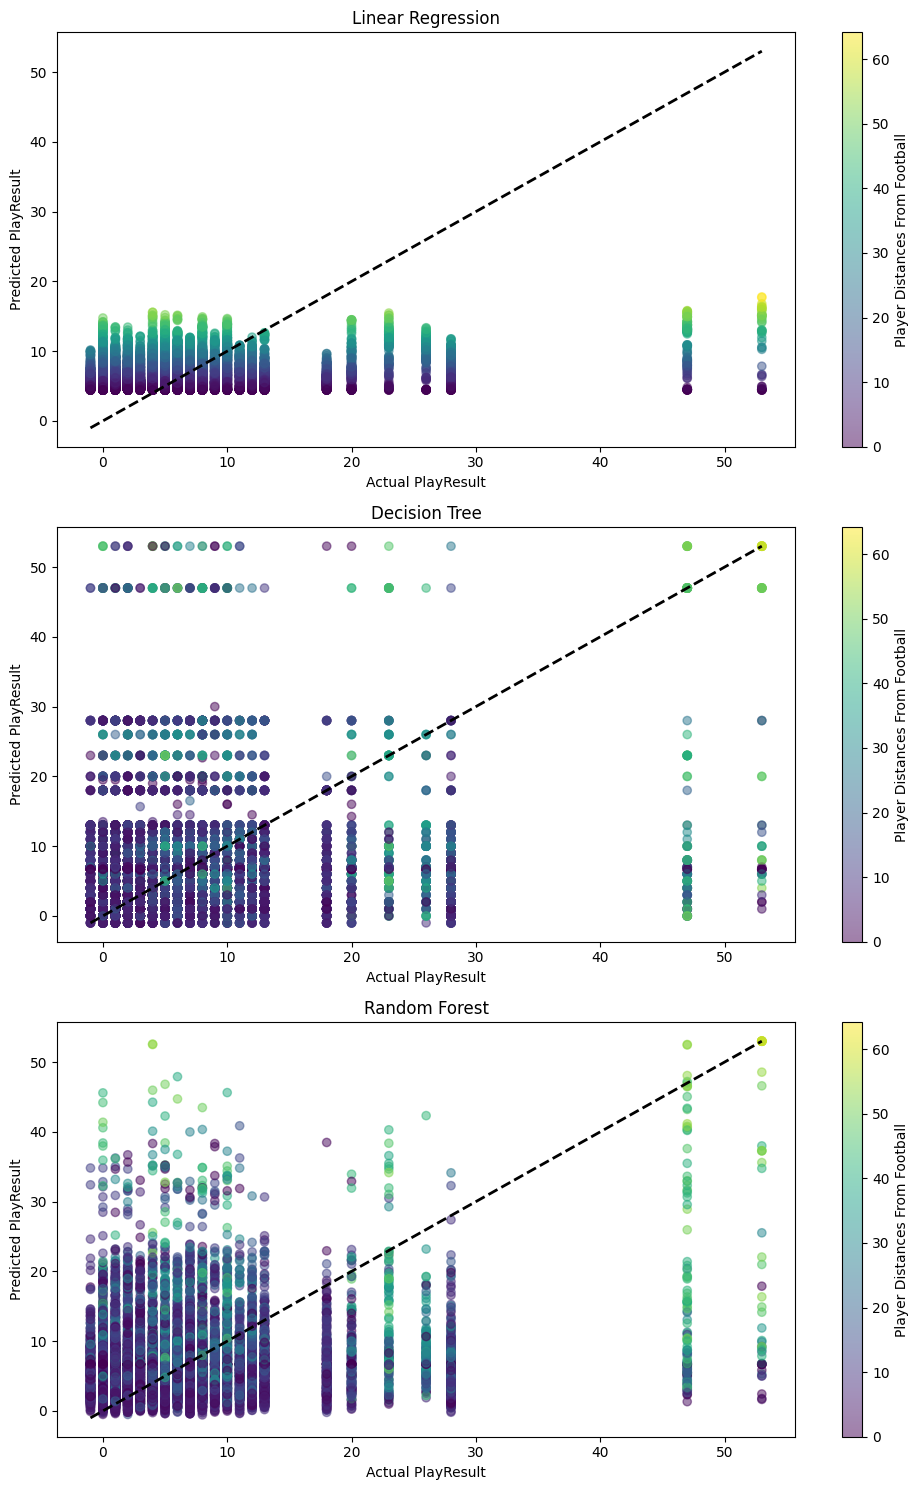

In [103]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Linear Regression
scatter = ax[0].scatter(y_test, y_pred_lr, alpha=0.5, c=X_test['football'], cmap='viridis')
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax[0].set_xlabel('Actual PlayResult')
ax[0].set_ylabel('Predicted PlayResult')
ax[0].set_title('Linear Regression')
fig.colorbar(scatter, ax=ax[0], label='Player Distances From Football')

# Decision Tree
scatter = ax[1].scatter(y_test, y_pred_dt, alpha=0.5, c=X_test['football'], cmap='viridis')
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax[1].set_xlabel('Actual PlayResult')
ax[1].set_ylabel('Predicted PlayResult')
ax[1].set_title('Decision Tree')
fig.colorbar(scatter, ax=ax[1], label='Player Distances From Football')

# Random Forest
scatter = ax[2].scatter(y_test, y_pred_rf, alpha=0.5, c=X_test['football'], cmap='viridis')
ax[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax[2].set_xlabel('Actual PlayResult')
ax[2].set_ylabel('Predicted PlayResult')
ax[2].set_title('Random Forest')
fig.colorbar(scatter, ax=ax[2], label='Player Distances From Football')

# Show the plot
plt.tight_layout()
plt.savefig('my_figure.png')
plt.show()